In [407]:
import pandas as pd
import numpy as np
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV, Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split

pd.set_option('display.float_format', lambda x: '%.5f' % x)

## 1. Read in and clean data

In [408]:
cardio_data = pd.read_csv('cardio_updated.csv')

Text(0.5, 1.0, 'heatmap of correlation matrix')

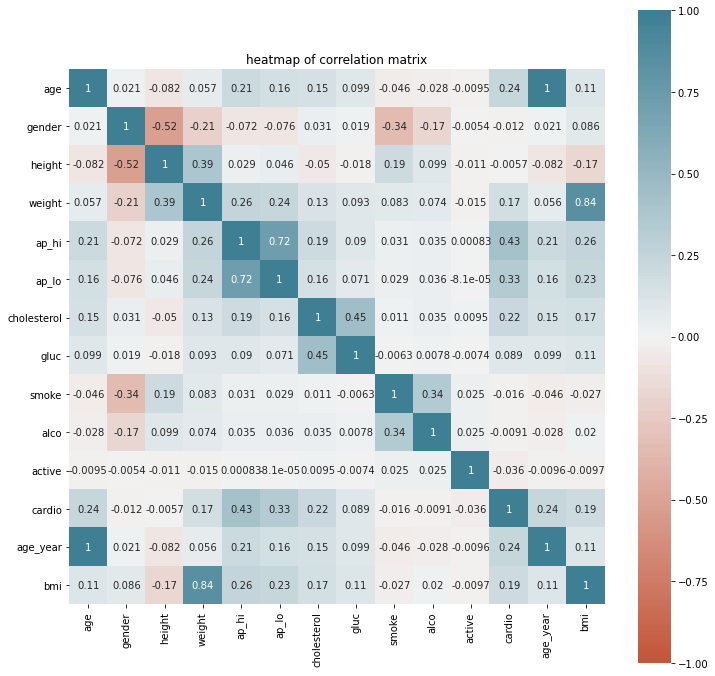

In [409]:
plt.figure(figsize = (12,12))
sns.heatmap(cardio_data.corr(), vmin = -1, vmax = 1, center = 0, 
           cmap = sns.diverging_palette(20,220,n=200), square = True, annot = True, 
          ).set_title("heatmap of correlation matrix")

In logistic regression, it is important that the variables not be correlated with one another. This would be an example of multicolinearity, which would weaken the model's predictions. Since BMI is a function of two other variables (height and weight), it would be best to use either BMI or height and weight as features. Since gender appears to be strongly negatively correlated with height, but not BMI, I will choose to retain BMI. I will also eliminate age_years and use age. Finally, I will attempt to use ap_hi/ap_lo and ap_hi + ap_lo instead of the two variables on their own.

In [410]:
cardio_data['ap_ratio'] = cardio_data.ap_hi/cardio_data.ap_lo
cardio_data['ap_sum'] = cardio_data.ap_hi + cardio_data.ap_lo
cardio_data.drop(columns=['ap_hi', 'ap_lo','age_year','weight','height'], inplace = True)

Text(0.5, 1.0, 'heatmap of correlation matrix')

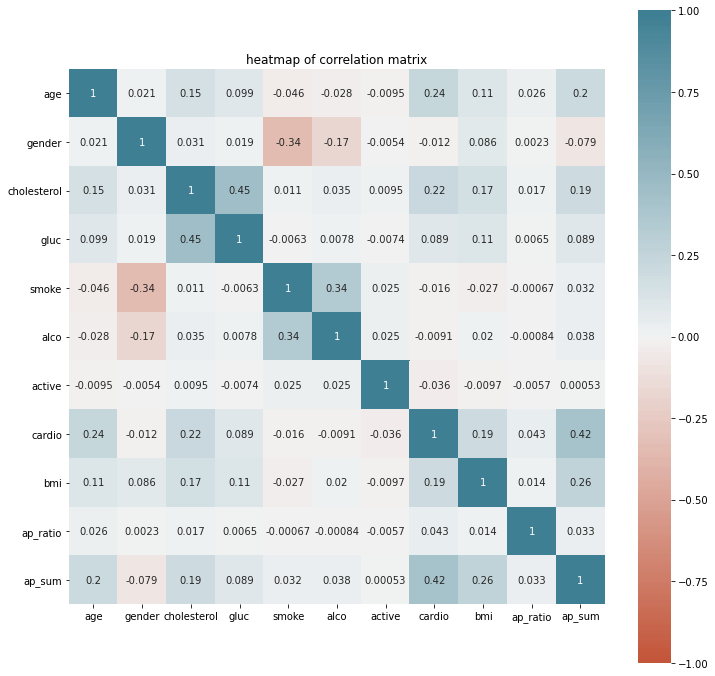

In [411]:
plt.figure(figsize = (12,12))
sns.heatmap(cardio_data.corr(), vmin = -1, vmax = 1, center = 0, 
           cmap = sns.diverging_palette(20,220,n=200), square = True, annot = True, 
          ).set_title("heatmap of correlation matrix")

Now, using 0.5 as the cutoff, there are no variables that are highly correlated with each other

In [412]:
cardio_data.head(10)

,age,gender,cholesterol,gluc,smoke,alco,active,cardio,bmi,ap_ratio,ap_sum
0,18393,0,1,1,0,0,1,0,21.96712,1.37500,190
1,20228,1,3,1,0,0,1,1,34.92768,1.55556,230
2,18857,1,3,1,0,0,0,1,23.50781,1.85714,200
3,17623,0,1,1,0,0,1,1,28.71048,1.50000,250
4,17474,1,1,1,0,0,0,0,23.01118,1.66667,160
5,21914,1,2,2,0,0,0,0,29.38468,1.50000,200
6,22113,1,3,1,0,0,1,0,37.72973,1.62500,210
7,22584,0,3,3,0,0,1,1,29.98359,1.44444,220
8,17668,1,1,1,0,0,1,0,28.44095,1.57143,180
9,19834,1,1,1,0,0,0,0,25.28257,1.83333,170


### Standardization

In [413]:
scaled_data = (cardio_data - cardio_data.min()) / (cardio_data.max() - cardio_data.min())
scaled_data.head(10)

,age,gender,cholesterol,gluc,smoke,alco,active,cardio,bmi,ap_ratio,ap_sum
0,0.58808,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.51001,0.00245,0.46328
1,0.73016,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.86741,0.00385,0.57627
2,0.62400,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.55250,0.00619,0.49153
3,0.52846,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,0.69596,0.00342,0.63277
4,0.51692,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.53880,0.00471,0.37853
5,0.86070,1.00000,0.50000,0.50000,0.00000,0.00000,0.00000,0.00000,0.71456,0.00342,0.49153
6,0.87611,1.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.94467,0.00439,0.51977
7,0.91258,0.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.73107,0.00299,0.54802
8,0.53194,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.68853,0.00398,0.43503
9,0.69965,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.60144,0.00601,0.40678


### Logistic Regression

In [414]:
train_data, val_data = train_test_split(scaled_data, train_size = 0.7, random_state = 123)
x_train = train_data.drop(columns = ['cardio'])
y_train = train_data['cardio']
x_val   = val_data.drop(columns = ['cardio'])
y_val   = val_data['cardio']

In [415]:
x_train.head(10)

,age,gender,cholesterol,gluc,smoke,alco,active,bmi,ap_ratio,ap_sum
22856,0.68355,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.70562,0.00259,0.46045
24365,0.62067,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.72665,0.00342,0.49153
24086,0.63113,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.81915,0.00439,0.51977
2178,0.98498,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.61034,0.00439,0.51977
35477,0.29477,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.60679,0.00471,0.37853
22246,0.99024,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.56263,0.00342,0.49153
60554,0.86388,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.87494,0.00398,0.43503
22204,0.78041,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.49321,0.00342,0.49153
32473,0.67712,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.55114,0.00342,0.49153
1196,0.55950,1.00000,0.50000,0.00000,0.00000,0.00000,1.00000,0.48895,0.00439,0.51977


In [416]:
start_time = time.time()
logit_model = LogisticRegressionCV(random_state = 0, 
                                   penalty = "l1", 
                                   solver = "liblinear", 
                                   max_iter = 250,
                                   Cs = range(90,210,10),
                                   cv = 10
                                  ).fit(x_train, y_train)
end_time = time.time()

In [417]:
training_time = end_time - start_time
print("Training time: " + str(training_time) + " seconds")

Training time: 153.0015799999237 seconds


In [418]:
var_coefs = {var : coef for var, coef in zip(x_train.columns, logit_model.coef_[0])}
zero_var_coefs =  var_coefs.copy()
nonzero_var_coefs =  var_coefs.copy()
for variable, coefficient in var_coefs.items():
    if coefficient != 0:
        del zero_var_coefs[variable]
    if coefficient == 0:
        del nonzero_var_coefs[variable]
zero_var_coefs

{}

In [419]:
nonzero_var_coefs

{'age': 1.7625493147631899,
 'gender': -0.025470891950501614,
 'cholesterol': 1.0258496633803238,
 'gluc': -0.19865128090696915,
 'smoke': -0.16917611146664707,
 'alco': -0.21352841073873446,
 'active': -0.22717778042593312,
 'bmi': 1.1135196238577085,
 'ap_ratio': 104.47231719169845,
 'ap_sum': 14.05887318671079}

Using the L1 penalty to perform regularization does not reduce any of the coefficients to zero in this case. This indicates that all of the features in the dataset are somewhat important in predicting the likelihood of cardiovascular disease.

In [420]:
#opitmal parameter
logit_model.C_

array([120])

In [421]:
# predictions
y_train_pred = logit_model.predict(x_train)
y_val_pred = logit_model.predict(x_val)

# predicted probabilities
y_train_prob = logit_model.predict_proba(x_train)
y_val_prob = logit_model.predict_proba(x_val)

fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_train_prob[:,1], pos_label = 1)
fpr_val, tpr_val, thresholds = metrics.roc_curve(y_val, y_val_prob[:,1], pos_label = 1)


model_metrics = pd.DataFrame({'train' : {'accuracy'  : metrics.accuracy_score(y_train, y_train_pred),
                                         'precision' : metrics.precision_score(y_train, y_train_pred),
                                         'recall'    : metrics.recall_score(y_train, y_train_pred),
                                         'f1'        : metrics.f1_score(y_train, y_train_pred),
                                         'auc'       : metrics.auc(fpr_train, tpr_train)},
                       
                               'val'  : {'accuracy'  : metrics.accuracy_score(y_val, y_val_pred),
                                         'precision' : metrics.precision_score(y_val, y_val_pred),
                                         'recall'    : metrics.recall_score(y_val, y_val_pred),
                                         'f1'        : metrics.f1_score(y_val, y_val_pred),
                                         'auc'       : metrics.auc(fpr_val, tpr_val)}
                             })

In [422]:
model_metrics

,train,val
accuracy,0.72618,0.72940
precision,0.75118,0.75269
recall,0.66081,0.65985
f1,0.70310,0.70322
auc,0.78893,0.79249


In [423]:
def plot_roc(fpr, tpr, title):
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.plot([0, 1], [0, 1], color = 'black', linestyle = "dashed")
    plt.title(title)
    plt.show()

In [424]:
def plot_cm(actual,predicted):
    cm = metrics.confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

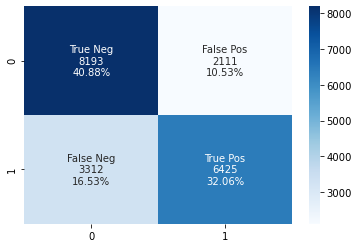

In [425]:
plot_cm(y_val,y_val_pred)

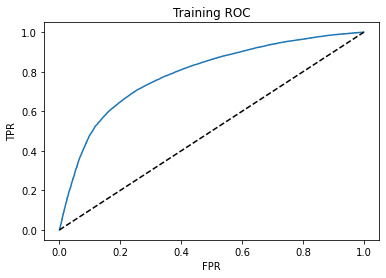

In [426]:
plot_roc(fpr_train, tpr_train, 'Training ROC')

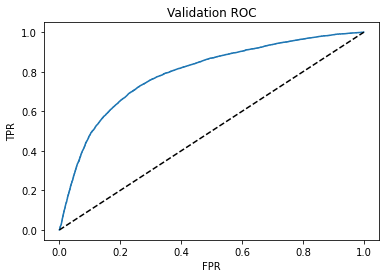

In [427]:
plot_roc(fpr_val, tpr_val, 'Validation ROC')

### One hot encoding

To attempt to improve the model, I will encode the cholesterol and glucose variables as dummy variables

In [428]:
convert_to_dummy = ['cholesterol',
                    'gluc']

for variable in convert_to_dummy:
    df = pd.get_dummies(cardio_data[variable], prefix = variable, drop_first = False)
    cardio_data = pd.concat([cardio_data, df], axis = 1)
    del cardio_data[variable]

In [429]:
scaled_data = (cardio_data - cardio_data.min()) / (cardio_data.max() - cardio_data.min())
scaled_data.head(10)

,age,gender,smoke,alco,active,cardio,bmi,ap_ratio,ap_sum,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0.58808,0.00000,0.00000,0.00000,1.00000,0.00000,0.51001,0.00245,0.46328,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
1,0.73016,1.00000,0.00000,0.00000,1.00000,1.00000,0.86741,0.00385,0.57627,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000
2,0.62400,1.00000,0.00000,0.00000,0.00000,1.00000,0.55250,0.00619,0.49153,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000
3,0.52846,0.00000,0.00000,0.00000,1.00000,1.00000,0.69596,0.00342,0.63277,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
4,0.51692,1.00000,0.00000,0.00000,0.00000,0.00000,0.53880,0.00471,0.37853,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
5,0.86070,1.00000,0.00000,0.00000,0.00000,0.00000,0.71456,0.00342,0.49153,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
6,0.87611,1.00000,0.00000,0.00000,1.00000,0.00000,0.94467,0.00439,0.51977,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000
7,0.91258,0.00000,0.00000,0.00000,1.00000,1.00000,0.73107,0.00299,0.54802,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000
8,0.53194,1.00000,0.00000,0.00000,1.00000,0.00000,0.68853,0.00398,0.43503,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000
9,0.69965,1.00000,0.00000,0.00000,0.00000,0.00000,0.60144,0.00601,0.40678,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000


In [430]:
train_data_encoded, val_data_encoded = train_test_split(scaled_data, train_size = 0.7, random_state = 123)
x_train_encoded      = train_data_encoded.drop(columns = ['cardio'])
y_train_encoded      = train_data_encoded['cardio']
x_val_encoded        = val_data_encoded.drop(columns = ['cardio'])
y_val_encoded        = val_data_encoded['cardio']

In [431]:
start_time = time.time()
logit_model_encoded = LogisticRegressionCV(random_state = 0, 
                                   penalty = "l1", 
                                   solver = "liblinear", 
                                   max_iter = 250,
                                   Cs = range(90,210,10),
                                   cv = 10
                                  ).fit(x_train_encoded, y_train_encoded)
end_time = time.time()

In [432]:
training_time = end_time - start_time
print("Training time: " + str(training_time) + " seconds")

Training time: 126.90602540969849 seconds


In [433]:
var_coefs = {var : coef for var, coef in zip(x_train_encoded.columns, logit_model_encoded.coef_[0])}
zero_var_coefs =  var_coefs.copy()
nonzero_var_coefs =  var_coefs.copy()
for variable, coefficient in var_coefs.items():
    if coefficient != 0:
        del zero_var_coefs[variable]
    if coefficient == 0:
        del nonzero_var_coefs[variable]
zero_var_coefs

{}

In [434]:
nonzero_var_coefs

{'age': 1.7543925065580996,
 'gender': -0.02385174639984473,
 'smoke': -0.16862801479029324,
 'alco': -0.2123235342640341,
 'active': -0.22804663481344686,
 'bmi': 1.1073239982756133,
 'ap_ratio': 104.75098573621443,
 'ap_sum': 14.056429200674163,
 'cholesterol_1': -3.3558496147495553,
 'cholesterol_2': -2.981300038019376,
 'cholesterol_3': -2.2189274299800483,
 'gluc_1': -3.0419553716528025,
 'gluc_2': -3.012221229459442,
 'gluc_3': -3.341856828251794}

In [435]:
#opitmal parameter
logit_model_encoded.C_

array([90])

In [439]:
# predictions
y_train_pred_encoded = logit_model_encoded.predict(x_train_encoded)
y_val_pred_encoded = logit_model_encoded.predict(x_val_encoded)

# predicted probabilities
y_train_prob_encoded = logit_model_encoded.predict_proba(x_train_encoded)
y_val_prob_encoded = logit_model_encoded.predict_proba(x_val_encoded)

fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train_encoded, y_train_prob_encoded[:,1], pos_label = 1)
fpr_val, tpr_val, thresholds = metrics.roc_curve(y_val_encoded, y_val_prob_encoded[:,1], pos_label = 1)

model_metrics_encoded = pd.DataFrame({'train' : {'accuracy'  : metrics.accuracy_score(y_train, y_train_pred_encoded),
                                         'precision' : metrics.precision_score(y_train, y_train_pred_encoded),
                                         'recall'    : metrics.recall_score(y_train, y_train_pred_encoded),
                                         'f1'        : metrics.f1_score(y_train, y_train_pred_encoded),
                                         'auc'       : metrics.auc(fpr_train, tpr_train)},
                       
                               'val'  : {'accuracy'  : metrics.accuracy_score(y_val, y_val_pred_encoded),
                                         'precision' : metrics.precision_score(y_val, y_val_pred_encoded),
                                         'recall'    : metrics.recall_score(y_val, y_val_pred_encoded),
                                         'f1'        : metrics.f1_score(y_val, y_val_pred_encoded),
                                         'auc'       : metrics.auc(fpr_val, tpr_val)}
                             })

In [440]:
model_metrics

,train,val
accuracy,0.72618,0.72940
precision,0.75118,0.75269
recall,0.66081,0.65985
f1,0.70310,0.70322
auc,0.78893,0.79249


In [441]:
model_metrics_encoded

,train,val
accuracy,0.72725,0.73000
precision,0.75377,0.75483
recall,0.65955,0.65801
f1,0.70352,0.70310
auc,0.78951,0.79289


Performing one hot-encoding on these variables reduced the computation time of the logistic model from 2 minutes to 1 minute and made a very small improvement in AUC, accuracy, and precision with a slight decrease in recall and F1. The results are generally the same, however. I will conclude that one-hot encoding these variables is a good performance enhancing strategy.

### Plot ROC (receiver operator characteristic) curve

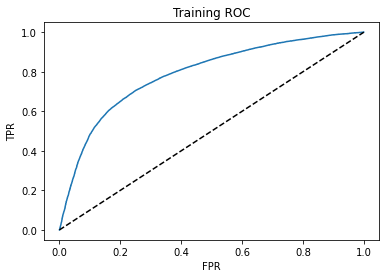

In [442]:
plot_roc(fpr_train, tpr_train, 'Training ROC')

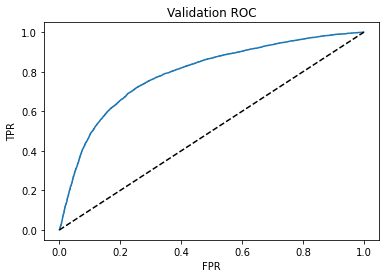

In [443]:
plot_roc(fpr_val, tpr_val, 'Validation ROC')

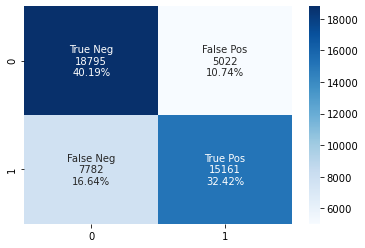

In [444]:
# confusion matrix on training data
plot_cm(y_train, y_train_pred)

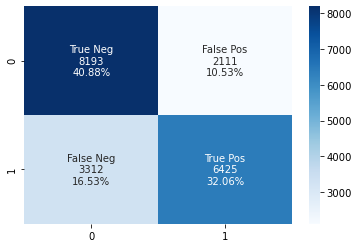

In [445]:
# confusion matrix on training data
plot_cm(y_val, y_val_pred)

This confusion matrix indicates that there are 3330 false negatives, which is slightly more than in the model without one-hot encoding. Therefore I will not use this model

### Finding the optimal threshold

I will now use the fitted model to find the optimal probability threshold. In the confusion matrix, we can see that there are a significant number of false negatives. These are patients whose cardiovascular disease has potentially gone undetected. This is much more serious than a false positive, a patient who may be at risk for cardio vascular disease but, upon further testing, was found not to have cardiovascular disease. These patients, despite not having cardiovascular disease, are still highly at risk and should take steps to improve their lifestyle. Therefore the optimal probability threshold should not be based on making the model as accurate as possible, but should be based on reducing the number of false negatives to be as low as possible.

In [446]:
thresh = np.arange(0.01, 1, .01) # create array 0.01, 0.02, 0.03, ..., 0.99

# create empty lists for each metric
false_negatives = []

# Loop through each threshold value - .01, .02, .03, ..., .99
for val in thresh:
    
    # get 1 / 0 predictions based off probability threshold
    pred = [1 if prob >= val else 0 for prob in y_train_prob[:,1]]
    
    # calculate precision, recall, accuracy, and f1-score
    negatives = metrics.confusion_matrix(y_train, pred)[1,0]
    
    # add precision, recall, accuracy, and f1-score to their respective lists
    false_negatives.append(negatives)

false_negatives = pd.DataFrame(data = {'false_negatives' : false_negatives}, index = thresh)
false_negatives

,false_negatives
0.01000,1
0.02000,1
0.03000,1
0.04000,3
0.05000,20
...,...
0.95000,22112
0.96000,22342
0.97000,22558
0.98000,22739


In [447]:
reasonable_threshold = false_negatives.index[np.where(false_negatives.false_negatives<=1000)].max()

In [448]:
pred = [1 if prob >= reasonable_threshold else 0 for prob in y_val_prob[:,1]]

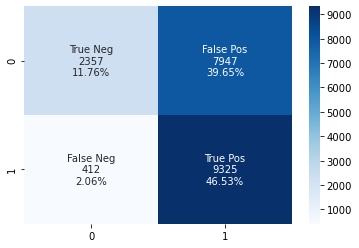

In [449]:
plot_cm(y_val, pred)

There is no way to eliminate all false negatives, or individuals with diagnosable cardiovascular disease that have gone undetected. Instead, we might choose a reasonable threshold such as 20% or 30%, but logistic regression may not be the best model for this.

### Choosing a threshold that maximizes F1 score

In [450]:
thresh = np.arange(0.01, 1, .01) # create array 0.01, 0.02, 0.03, ..., 0.99

# create empty lists for each metric
precision_values = []
recall_values = []
acc_values = []
f1_values = []

# Loop through each threshold value - .01, .02, .03, ..., .99
for val in thresh:
    
    # get 1 / 0 predictions based off probability threshold
    pred = [1 if prob >= val else 0 for prob in y_train_prob[:,1]]
    
    # calculate precision, recall, accuracy, and f1-score
    precision = metrics.precision_score(y_train, pred)
    recall = metrics.recall_score(y_train, pred)
    accuracy = metrics.accuracy_score(y_train, pred)
    f1_score = metrics.f1_score(y_train, pred)
    
    # add precision, recall, accuracy, and f1-score to their respective lists
    precision_values.append(precision)
    recall_values.append(recall)
    acc_values.append(accuracy)
    f1_values.append(f1_score)

# put precision, recall, and accuracy values into a data frame
result = pd.DataFrame()
result["threshold"] = thresh
result["precision"] = precision_values
result["recall"] = recall_values
result["accuracy"] = acc_values
result["f1_score"] = f1_values

result

,threshold,precision,recall,accuracy,f1_score
0,0.01000,0.49066,0.99996,0.49068,0.65831
1,0.02000,0.49069,0.99996,0.49072,0.65833
2,0.03000,0.49091,0.99996,0.49117,0.65852
3,0.04000,0.49177,0.99987,0.49292,0.65928
4,0.05000,0.49263,0.99913,0.49467,0.65989
...,...,...,...,...,...
94,0.95000,0.84796,0.03622,0.52393,0.06947
95,0.96000,0.85127,0.02620,0.51995,0.05083
96,0.97000,0.84245,0.01678,0.51604,0.03291
97,0.98000,0.80315,0.00889,0.51264,0.01759


In [451]:
optimal_thresh = result.iloc[result.f1_score.idxmax()]
optimal_thresh

threshold   0.38000
precision   0.65538
recall      0.81912
accuracy    0.69991
f1_score    0.72816
Name: 37, dtype: float64

In [452]:
pred = [1 if prob >= optimal_thresh.threshold else 0 for prob in y_val_prob[:,1]]

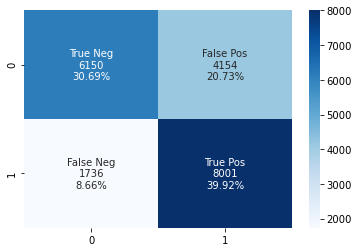

In [453]:
plot_cm(y_val,pred)

The above represents the confusion matrix for predictions made using the F1 score maximizing threshold